In [1]:
!ls -GFlash  ../input

total 1.3G
4.0K drwxr-xr-x 2 root 4.0K Jul 15 20:56 ./
4.0K drwxr-xr-x 6 root 4.0K Sep  1 08:15 ../
5.9M -rw-r--r-- 1 root 5.8M Jul 15 20:56 sample_submission.csv
 25M -rw-r--r-- 1 root  25M Jul 15 20:56 test_identity.csv
585M -rw-r--r-- 1 root 585M Jul 15 20:56 test_transaction.csv
 26M -rw-r--r-- 1 root  26M Jul 15 20:56 train_identity.csv
652M -rw-r--r-- 1 root 652M Jul 15 20:56 train_transaction.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns

import gc
import warnings
from time import time
import datetime
from tqdm import tqdm_notebook
warnings.simplefilter('ignore')

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score


# Training Data
train_id = pd.read_csv('../input/train_identity.csv')
train_tr = pd.read_csv('../input/train_transaction.csv')

# Test Data
test_id = pd.read_csv('../input/test_identity.csv')
test_tr = pd.read_csv('../input/test_transaction.csv')

print(
    'Data Shape:',
    train_tr.shape,
    train_id.shape,
    test_tr.shape,
    test_id.shape,
    sep='\n'
)

# Merge transaction and id data
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

Data Shape:
(590540, 394)
(144233, 41)
(506691, 393)
(141907, 41)


In [3]:
# Reduce memory usage
del test_id, test_tr, train_id, train_tr
gc.collect()

56

## Feature Engineering

In [4]:
# # Missing Value Filter

# def get_missing(df):
#     missing = df.isnull().sum()
#     return missing[missing > 500000]

# drop_cols = get_missing(train_transaction).index.tolist()
# print(drop_cols)

# # Redundant Columns

# drop_cols = drop_cols + ['isFraud', 'TransactionDT', 'TransactionID']
# print(drop_cols)

In [5]:
# Useful feature columns
feature_cols = [
    'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
    'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
    'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
    'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
    'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
    'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
    'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
    'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
    'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
    'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
    'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
    'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
    'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
    'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
    'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
    'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
    'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'
]

In [6]:
drop_cols = [col for col in train.columns if col not in feature_cols]
drop_cols.remove('isFraud')
drop_cols.remove('TransactionID')
drop_cols.remove('TransactionDT')

print('Drop feature count = {}'.format(len(drop_cols)))

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

Drop feature count = 152


In [7]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [8]:
# Count encoding

for feature in ['id_34', 'id_36']:
    if feature in feature_cols:
        train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in feature_cols:
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [9]:
# Label encode object data
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [10]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test_X = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [11]:
del train, test
gc.collect()

63

In [12]:
print(X.shape, test_X.shape, sep='\n')

(590540, 288)
(506691, 288)


# Model Training

In [13]:
# Set hyperparameters
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [14]:
# Cross validate lgb model using time series split

folds = TimeSeriesSplit(n_splits=5)

auc = list()
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

training_start_time = time()
for fold, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    train_data = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, train_data, 10000, valid_sets = [train_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importance['fold_{}'.format(fold + 1)] = clf.feature_importance()
    auc.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('---------------')
print('Training Time = {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(auc))
print('---------------')

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999994	valid_1's auc: 0.904399
Early stopping, best iteration is:
[1024]	training's auc: 0.999996	valid_1's auc: 0.90448
Fold 1 finished in 0:02:47.787487
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.99991	valid_1's auc: 0.923903
Early stopping, best iteration is:
[727]	training's auc: 0.999275	valid_1's auc: 0.924394
Fold 2 finished in 0:04:48.812560
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999182	valid_1's auc: 0.915936
Early stopping, best iteration is:
[922]	training's auc: 0.998773	valid_1's auc: 0.916113
Fold 3 finished in 0:08:15.273097
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.997236	valid_1's auc: 0.935389
Early stopping, best iteration is:
[1068]	training's auc: 0.997813	valid_1's 

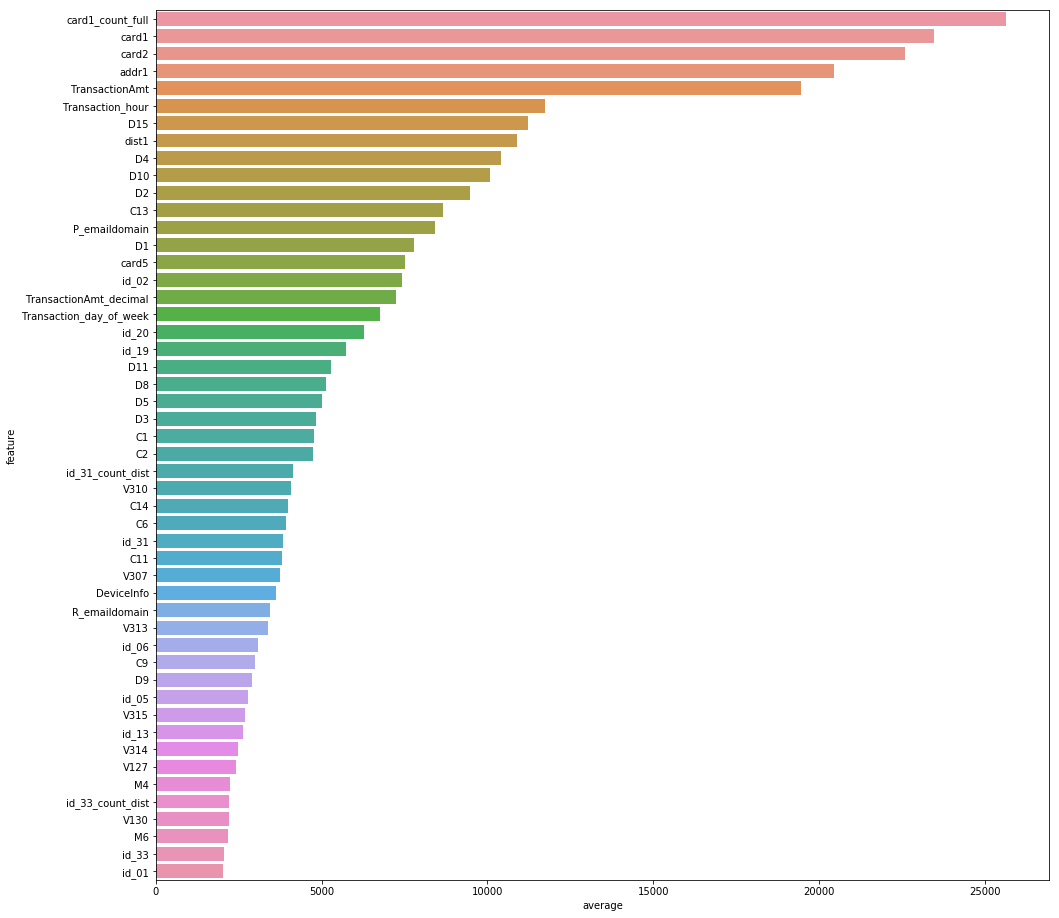

In [15]:
# Display feature importance scores

feature_importance['average'] = feature_importance[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 16))
importance_score = feature_importance.sort_values(by='average', ascending=False).head(50)
sns.barplot(data = importance_score, x = 'average', y = 'feature')

In [16]:
# # Choose final model, based on best iteration
# best_iteration = clf.best_iteration
# clf = lgb.LGBMClassifier(**params, num_boost_round=best_iteration)
# clf.fit(X, y)

# # Get predictions
# predictions = clf.predict_proba(test_X)[:,1]